In [1]:
if 'google.colab' in str(get_ipython()):
    !git clone https://github.com/lukewood/rl-routing && cd rl-routing && pip install .

In [2]:
import networkx as nx
graph=nx.random_internet_as_graph(20)
pos = nx.spring_layout(graph)
nx.set_node_attributes(graph, pos, "pos")

In [3]:
class ShortestPathAgent():
    def actions(self, observation):
        actions = -1*np.ones((len(graph.nodes), len(graph.nodes)), dtype=np.int32)
        adj_matrix, wires, packets, routes = observation
        # shortest path routes are returned as part of observation
        # as a baseline we construct an action based on this
        for f in routes.keys():
            for t in routes[f].keys():
                actions[f][t] = routes[f][t]
        return actions

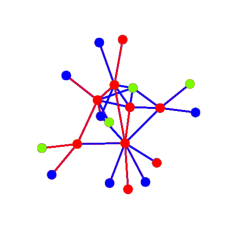

Reward 4
Total 171


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import time
from collections import defaultdict
from IPython.display import clear_output
import numpy as np

from rl_routing import NetworkEnv #, standard_preprocessing

def draw_output(img):
    plt.axis("off")
    plt.imshow(img)
    plt.show()

env = NetworkEnv(graph=graph, fig=Figure(figsize=(6, 6)))
i = 100

agent = ShortestPathAgent()
observation = env.reset(initial_packets=5)

for _ in range(1000):
    env.create_packets(n=5)

    actions = agent.actions(observation)
    # actions is a list of steps to be taken for each node
    # the packet with the highest value (earliest created) is sent based on step's input
    observation, reward, done, info = env.step(actions)
    
    img = env.render()
    draw_output(img)
    print("Step Reward", reward)
    print("Total Reward", env.completed_packets)

    clear_output(wait=True)
    time.sleep(1000/1000)
draw_output(env.render())